# Group Analysis

In [1]:
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from src import plotting

In [2]:
regress_gaze = False
if regress_gaze:
    equal_train_test = ['subj001', 'subj003', 'subj008', 'subj009', 'subj010']
else:
    equal_train_test = ['subj008', 'subj009', 'subj010']
extra_test = [f'subj{str(subj).zfill(3)}' for subj in range(11, 14)]
test_only = ['subj005', 'subj006', 'subj007']

gaze_subjs = [f'subj{str(subj).zfill(3)}' for subj in range(5, 14)]
fmri_subjs = [f'sub-{str(subj).zfill(2)}' for subj in range(1, 5)]
eeg_metric = 'correlation'
fmri_metric = 'decoding'

process = 'Group_Analysis'
top_path = '/Users/emcmaho7/Dropbox/projects/SI_EEG/SIEEG_analysis'
input_path = f'{top_path}/data/interim'
out_path = f'{top_path}/data/interim/{process}'
figure_path = f'{top_path}/reports/figures/{process}'
Path(out_path).mkdir(parents=True, exist_ok=True)
Path(figure_path).mkdir(parents=True, exist_ok=True)

In [3]:
rois = ['EVC', 'MT', 'EBA',
        'LOC', 'FFA', 'PPA',
        'pSTS', 'face-pSTS', 'aSTS']
features = ['alexnet', 'moten', 'indoor',
                 'expanse', 'object_directedness', 'agent_distance',
                 'facingness', 'joint_action', 'communication', 
                 'valence', 'arousal']
annotated_features = ['indoor', 'expanse', 'object_directedness', 
                 'agent_distance', 'facingness', 'joint_action', 
                 'communication', 'valence', 'arousal']

In [4]:
def load_files(files, cat=None, cat_order=None, subj_include=set50_subjs):
    group = []
    subjs = []
    for file in files:
        subj = file.split('/')[-1].split('_')[0]
        if subj in subj_include: 
            subjs.append(subj)
            df = pd.read_csv(file)
            df['subj'] = subj
            if 'Unnamed: 0' in df.columns:
                df.drop(columns=['Unnamed: 0'], inplace=True)
            group.append(df)
    group = pd.concat(group)
    if cat and cat_order:
        cat_type = pd.CategoricalDtype(categories=cat_order, ordered=True)
        group[cat] = group[cat].astype(cat_type)
    return group, subjs

def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

## Pairwise decoding

In [5]:
pairwise_decoding, subjs = load_files(glob(f'{input_path}/PairwiseDecoding/*reg-gaze-{regress_gaze}.csv.gz'),
                                      subj_include=set250_subjs)
print(subjs)
decoding_avg = pairwise_decoding.groupby(['time', 'subj']).mean(numeric_only=True).reset_index()
_, ax = plt.subplots()
ymin, ymax = decoding_avg['distance'].min(), decoding_avg['distance'].max()
sns.lineplot(x='time', y='distance', data=decoding_avg, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time (s)')     
ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=0.5, xmin=decoding_avg.time.min(), xmax=decoding_avg.time.max(),
        colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([decoding_avg.time.min(), decoding_avg.time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{figure_path}/pairwise-decoding_nvideos-250_reg-gaze-{regress_gaze}.png')

NameError: name 'set250_subjs' is not defined

['subj005', 'subj006', 'subj007']


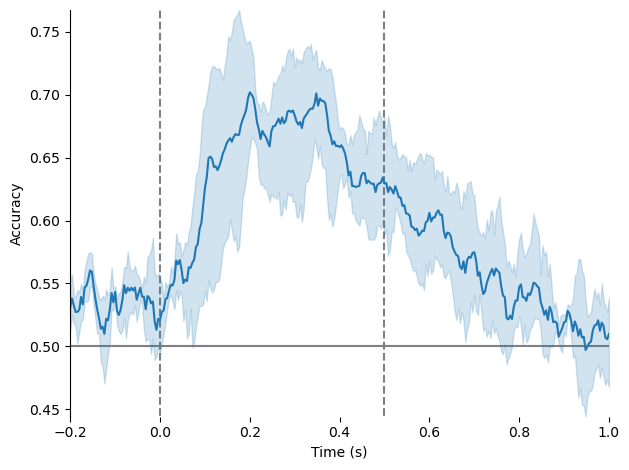

In [6]:
pairwise_decoding, subjs = load_files(glob(f'{input_path}/PairwiseDecoding/*reg-gaze-{regress_gaze}.csv.gz'),
                                      subj_include=set50_subjs)
print(subjs)
decoding_avg = pairwise_decoding.groupby(['time', 'subj']).mean(numeric_only=True).reset_index()
_, ax = plt.subplots()
ymin, ymax = decoding_avg['distance'].min(), decoding_avg['distance'].max()
sns.lineplot(x='time', y='distance', data=decoding_avg, ax=ax)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Time (s)')     
ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
        colors='gray', linestyles='dashed', zorder=0)
ax.hlines(y=0.5, xmin=decoding_avg.time.min(), xmax=decoding_avg.time.max(),
        colors='gray', linestyles='solid', zorder=0)
ax.set_xlim([decoding_avg.time.min(), decoding_avg.time.max()])
ax.set_ylim([ymin, ymax])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.savefig(f'{figure_path}/pairwise-decoding_nvideos-50_reg-gaze-{regress_gaze}.png')

## Feature - EEG RSA

In [5]:
def plot_feature_eeg_rsa(rsa, out_file):
    feature_group = rsa.groupby('feature')
    _, axes = plt.subplots(int(np.ceil(len(features)/3)), 3,
                        figsize=(10,8),
                        sharey=True, constrained_layout=True)
    axes = axes.flatten()
    trim_axs(axes, len(features))
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (feature, time_corr) in zip(axes, feature_group):
        sns.lineplot(x='time', y='Spearman rho', data=time_corr, ax=ax)
        if feature in ['alexnet', 'expanse', 'facingness', 'valence']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')
            
        if feature in ['communication', 'valence', 'arousal']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
            ax.tick_params(axis='x', which='both', length=0)
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr.time.min(), xmax=time_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([time_corr.time.min(), time_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(feature)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()


In [ ]:
eeg_metric = 'decoding'
rsa, subjs = load_files(glob(f'{input_path}/EEG_RSA/*feature_EEG-{eeg_metric}_reg-gaze-{regress_gaze}_rsa.csv'),
                        cat='feature', cat_order=features,
                        subj_include=set250_subjs)
print(eeg_metric, subjs)
out_file = f'{figure_path}/feature_EEG-{eeg_metric}_nvideos-250_reg-gaze-{regress_gaze}_rsa.png'
plot_feature_eeg_rsa(rsa, out_file)

In [12]:
regress_gaze = True
rsa, subjs = load_files(glob(f'{input_path}/EEG_RSA/*feature_EEG-{eeg_metric}_reg-gaze-{regress_gaze}_rsa*.csv'),
                        cat='feature', cat_order=features,
                        subj_include=set50_subjs)
print(eeg_metric, subjs)
out_file = f'{figure_path}/feature_EEG-{eeg_metric}_nvideos-50_reg-gaze-{regress_gaze}_rsa.png'
plot_feature_eeg_rsa(rsa, out_file)

decoding ['subj005', 'subj007', 'subj006']


/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_55452/1725940735.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


## fMRI - EEG RSA

In [10]:
def plot_fmri_eeg_rsa(rsa, out_file):
    roi_group = rsa.groupby('roi')
    _, axes = plt.subplots(3, 3, sharey=True, sharex=True)
    axes = axes.flatten()
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (roi, roi_corr) in zip(axes, roi_group):
        sns.lineplot(x='time', y='Spearman rho', data=roi_corr, ax=ax)
        if roi in ['EVC', 'LOC', 'pSTS']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')

        if roi in ['pSTS', 'face-pSTS', 'aSTS']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.tick_params(axis='x', which='both', length=0)

        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=roi_corr.time.min(), xmax=roi_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([roi_corr.time.min(), roi_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(roi)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [11]:
rsa, subjs = load_files(glob(f'{input_path}/EEG_RSA/*fMRI-{fmri_metric}_EEG-{eeg_metric}_rsa.csv'),
                        cat='roi', cat_order=rois,
                        subj_include=set250_subjs)
out_file = f'{figure_path}/fMRI-{fmri_metric}_EEG-{eeg_metric}_nvideos-250_reg-gaze-{regress_gaze}_rsa.png'
plot_fmri_eeg_rsa(rsa, out_file)

In [12]:
rsa, subjs = load_files(glob(f'{input_path}/EEG_RSA/*fMRI-{fmri_metric}_EEG-{eeg_metric}_rsa.csv'),
                        cat='roi', cat_order=rois,
                        subj_include=set50_subjs)
out_file = f'{figure_path}/fMRI-{fmri_metric}_EEG-{eeg_metric}_nvideos-50_reg-gaze-{regress_gaze}_rsa.png'
plot_fmri_eeg_rsa(rsa, out_file)

## fMRI-EEG Decoding

In [13]:
def plot_fmri_eeg_decoding(rsa, out_file):
    roi_group = rsa.groupby('roi_name')
    _, axes = plt.subplots(3, 3, sharey=True, sharex=True)
    axes = axes.flatten()
    ymin, ymax = rsa['score'].min(), rsa['score'].max()
    for ax, (roi, roi_corr) in zip(axes, roi_group):
        sns.lineplot(x='time', y='score', data=roi_corr, ax=ax)
        if roi in ['EVC', 'LOC', 'pSTS']:
            ax.set_ylabel('Prediction (r)')
        else:
            ax.set_ylabel('')

        if roi in ['pSTS', 'face-pSTS', 'aSTS']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.tick_params(axis='x', which='both', length=0)

        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=roi_corr.time.min(), xmax=roi_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([roi_corr.time.min(), roi_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(roi)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [15]:
rsa, subjs = load_files(glob(f'{input_path}/fMRIDecoding/*reg-gaze-{regress_gaze}_decoding.csv'),
                        cat='roi_name', cat_order=rois,
                        subj_include=['subj001'])
out_file = f'{figure_path}/fMRI_EEG_reg-gaze-{regress_gaze}_decoding.png'
plot_fmri_eeg_decoding(rsa, out_file)

## Feature - EEG Decoding

In [13]:
def plot_decoding(out_file, results, features):
    feature_group = results.groupby('feature')
    _, axes = plt.subplots(int(np.ceil(len(features)/3)), 3,
                        figsize=(10,8),
                        sharey=True, constrained_layout=True)
    axes = axes.flatten()
    trim_axs(axes, len(features))
    ymin, ymax = results['r'].min(), results['r'].max()
    for ax, (feature, time_corr) in zip(axes, feature_group):
        sns.lineplot(x='time', y='r', data=time_corr, ax=ax)
        if feature in ['indoor', 'agent_distance', 'communication']:
            ax.set_ylabel('Prediction (r)')
        else:
            ax.set_ylabel('')
            
        if feature in ['communication', 'valence', 'arousal']:
            ax.set_xlabel('Time (s)')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels([])
            ax.tick_params(axis='x', which='both', length=0)
        ax.vlines(x=[0, 0.5], ymin=0, ymax=ymax,
                colors='gray', linestyles='dashed', zorder=0)
        ax.hlines(y=0, xmin=time_corr.time.min(), xmax=time_corr.time.max(),
                colors='gray', linestyles='solid', zorder=0)
        ax.set_xlim([time_corr.time.min(), time_corr.time.max()])
        ax.set_ylim([ymin, ymax])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(feature)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [16]:
rsa, subjs = load_files(glob(f'{input_path}/FeatureDecoding/*reg-gaze-{regress_gaze}_decoding.csv'),
                        cat='feature', cat_order=features,
                        subj_include=set250_subjs)
out_file = f'{figure_path}/feature_EEG_nvideos-250_reg-gaze-{regress_gaze}_decoding.png'
plot_decoding(out_file, rsa, features)

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_18102/2229644866.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [17]:
rsa, subjs = load_files(glob(f'{input_path}/FeatureDecoding/*reg-gaze-{regress_gaze}_decoding.csv'),
                        cat='feature', cat_order=features,
                        subj_include=set50_subjs)
out_file = f'{figure_path}/feature_EEG_nvideos-50_reg-gaze-{regress_gaze}_decoding.png'
plot_decoding(out_file, rsa, features)

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_18102/2229644866.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


## Feature - fMRI RSA

In [ ]:
def plot_feature_fMRI_rsa(rsa, out_file):
    feature_group = rsa.groupby('roi')
    _, axes = plt.subplots(3, 3, figsize=(10,8),
                            sharey=True, sharex=True)
    axes = axes.flatten()
    ymin, ymax = rsa['Spearman rho'].min(), rsa['Spearman rho'].max()
    for ax, (roi, feature_df) in zip(axes, feature_group):
        sns.barplot(x='feature', y='Spearman rho',
                    data=feature_df, ax=ax, color='gray')
        if roi in ['EVC', 'LOC', 'pSTS']:
            ax.set_ylabel('Spearman rho')
        else:
            ax.set_ylabel('')
            
        if roi in ['pSTS', 'face-pSTS', 'aSTS']:
            ax.set_xticklabels(features, rotation=90, ha='center')
        else:
            ax.tick_params(axis='x', which='both', length=0)

        for bar, feature in zip(ax.patches, features):
            color = plotting.feature2color(feature)
            bar.set_color(color)
        
        ax.set_xlabel('')
        ax.set_ylim([ymin, ymax])
        ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
            colors='gray', linestyles='solid', zorder=1)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_title(roi)
    plt.tight_layout()
    plt.savefig(out_file)
    plt.close()

In [ ]:
rsa, _ = load_files(glob(f'{input_path}/fMRI_RSA/*_rsa-{fmri_metric}.csv'),
                    cat='feature', cat_order=features,
                    subj_include=fmri_subjs)
rsa['roi'] = rsa['roi'].astype(pd.CategoricalDtype(categories=rois, ordered=True))
out_file = f'{figure_path}/feature_fMRI-{fmri_metric}_rsa.png'
plot_feature_fMRI_rsa(rsa, out_file)

## Gaze decoding

In [8]:
def plot_feature_gaze_decoding(results, out_file):
    _, ax = plt.subplots()
    sns.barplot(x='feature', y='r', data=results, errorbar=None, ax=ax, color='gray')
    sns.swarmplot(x='feature', y='r', hue='subj', data=results, ax=ax, palette='husl')
    ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],
        colors='black', linestyles='solid', zorder=1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xticklabels(features, rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('Prediction (r)')
    ax.legend(bbox_to_anchor=(.95, .95))
    plt.tight_layout()
    plt.savefig(out_file)

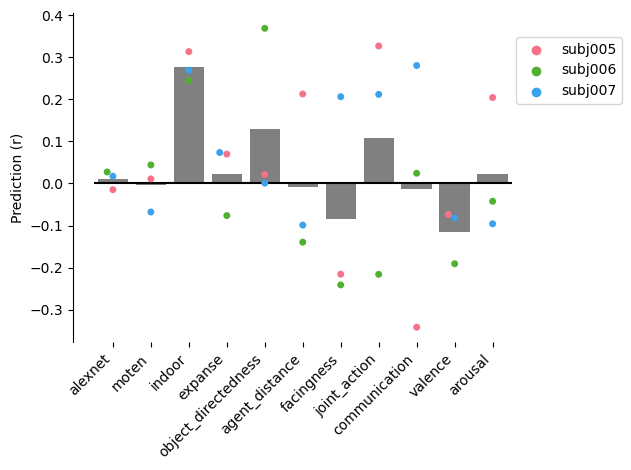

In [11]:
results, _ = load_files(glob(f'{input_path}/GazeDecoding/*decoding.csv'),
                    cat='feature', cat_order=features,
                    subj_include=set50_subjs)
results['subj'] = results['subj'].astype(pd.CategoricalDtype(categories=set50_subjs, ordered=True))
out_file = f'{figure_path}/feature_gaze_rsa.png'
plot_feature_gaze_decoding(results, out_file)